# Graph Coloring Problem with Quantum Alternating Operator Ansatz
In this tutorial, we will solve the Graph Coloring Problem using the Quantum Alternating Operator Ansatz.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import networkx as nx
import qiskit.primitives as qk_pr

import jijmodeling as jm
import jijmodeling_transpiler.core as jmt

import qamomile.core as qm
from qamomile.qiskit import QiskitTranspiler
from qamomile.core.circuit.drawer import plot_quantum_circuit

First, we will implement the mathematical model of the graph coloring problem using JijModeling.

In [2]:
def graph_coloring_problem() -> jm.Problem:
    # define variables
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    N = jm.Placeholder("N")
    x = jm.BinaryVar("x", shape=(V, N))
    n = jm.Element("i", belong_to=(0, N))
    v = jm.Element("v", belong_to=(0, V))
    e = jm.Element("e", belong_to=E)
    # set problem
    problem = jm.Problem("Graph Coloring")
    # set one-hot constraint that each vertex has only one color

    problem += jm.Constraint("one-color", x[v, :].sum() == 1, forall=v)
    # set objective function: minimize edges whose vertices connected by edges are the same color
    problem += jm.sum([n, e], x[e[0], n] * x[e[1], n])
    return problem

problem = graph_coloring_problem()
problem

Next, we will create an instance of the problem.

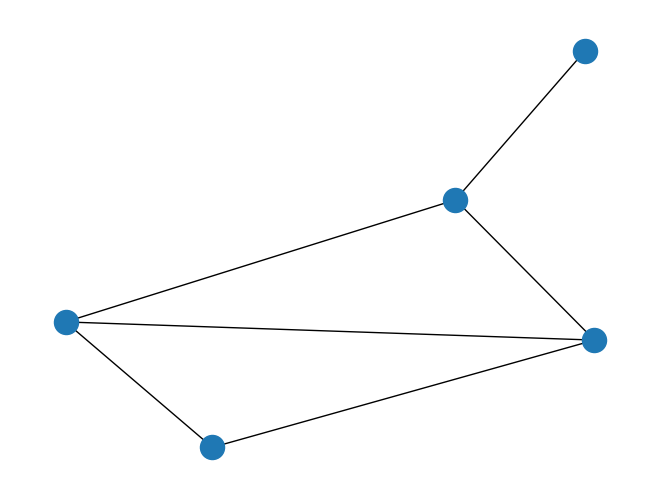

In [3]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (1, 2), (1, 3), (2, 3), (3, 4), (2, 4)])
nx.draw(G)

In [4]:
inst_E = [list(edge) for edge in G.edges]
color_num = 3
num_nodes = G.number_of_nodes()
instance_data = {"V": num_nodes, "N": color_num, "E": inst_E}
num_qubits = num_nodes * color_num

# Quantum Alternating Operator Ansatz
Next, let's try solving the graph coloring problem using the Quantum Alternating Operator Ansatz. The Quantum Alternating Operator Ansatz[2] is a modification of QAOA, where the mixer is changed from an $X$-mixer to a mixer tailored to the problem, ensuring that only solutions satisfying the constraints are searched for. For more detailed information, please refer to the original paper. Here, we will look at how to implement it in JTQ.

For the Graph Coloring problem, there is a one-hot constraint:

$$
\sum_k x_{v,k} = 1\quad \forall v
$$

However, turning this into an $XY$-mixer is the Quantum Alternating Operator Ansatz approach to the Graph Coloring problem.

In [5]:
compiled_instance = jmt.compile_model(problem, instance_data)
qaoa_converter = qm.qaoa.QAOAConverter(compiled_instance)

In [6]:
gamma_1 = qm.circuit.Parameter("gamma_1")
# Delete one-color penalty.
qaoa_converter.ising_encode(multipliers={"one-color": 0.0})
# Get exp(-i gamma H_P) circuit without mixer circuit.  
qaoa_cost_circuit = qaoa_converter.get_cost_ansatz(gamma_1)
qaoa_cost = qaoa_converter.get_cost_hamiltonian()

Next, we will create an $XY$-mixer. The $XY$-mixer can be written as

$$
XY_{ij} = \frac{1}{2}\left(X_iX_j + Y_iY_j \right).
$$

This is an operator that swaps the bits 1 and 0 in bit $i,j$. Therefore, it can transform a bit string $100$, which satisfies the one-hot constraint, into another bit string $010$, which also satisfies the one-hot constraint.

Here, the only part under the one-hot constraint is related to color, so in terms of the mathematical model, we need to transform the bits between $x_{v0}$ and $x_{v1}$.
On the other hand, as these variables are usually embedded in qubits, it is necessary to remember which bit corresponds to which variable when constructing the algorithm and handle them appropriately.
In JTQ, the correspondence of variables is contained in var_map inside CompiledInstance.
```python
var_map['variable_name'][indices]
```
You can check which qubit corresponds to a variable in the mathematical model in this way.
Let's use this to create an $XY$-mixer.

What we want here is the transformation between $x_{v,k}$ and $x_{v,k+1}$, so we can obtain the index of the corresponding qubit by accessing compiled_instance.var_map.var_map["x"][(i,k)]."

In [7]:
def create_xy_mixer(
    beta: qm.circuit.Parameter,
    num_nodes: int,
    num_color: int,
    compiled_instance: jmt.CompiledInstance,
):
    n = num_color * num_nodes
    qc = qm.circuit.QuantumCircuit(n, name="XY-mixer")
    var_map = compiled_instance.var_map.var_map["x"]
    # even
    for i in range(num_nodes):
        for k in range(0, num_color - 1, 2):
            qc.rxx(beta, var_map[(i, k)], var_map[(i, k + 1)])
            qc.ryy(beta, var_map[(i, k)], var_map[(i, k + 1)])

    # odd
    for i in range(num_nodes):
        for k in range(1, num_color - 1, 2):
            qc.rxx(beta, var_map[(i, k)], var_map[(i, k + 1)])
            qc.ryy(beta, var_map[(i, k)], var_map[(i, k + 1)])

    # ini-last
    if num_color % 2 == 1:
        for i in range(num_nodes):
            qc.rxx(beta, var_map[(i, 0)], var_map[(i, num_color - 1)])
            qc.ryy(beta, var_map[(i, 0)], var_map[(i, num_color - 1)])
    return qc

In [8]:
def create_initial_state(
    compiled_instance: jmt.CompiledInstance, num_nodes: int, num_color: int
):
    n = num_color * num_nodes
    qc = qm.circuit.QuantumCircuit(n)
    var_map = compiled_instance.var_map.var_map["x"]
    for i in range(num_nodes):
        qc.x(var_map[(i, 0)])  # set all nodes to color 0
    return qc

Now that the Ansatz has been created, we would like to run the Quantum Alternating Operator Ansatz.

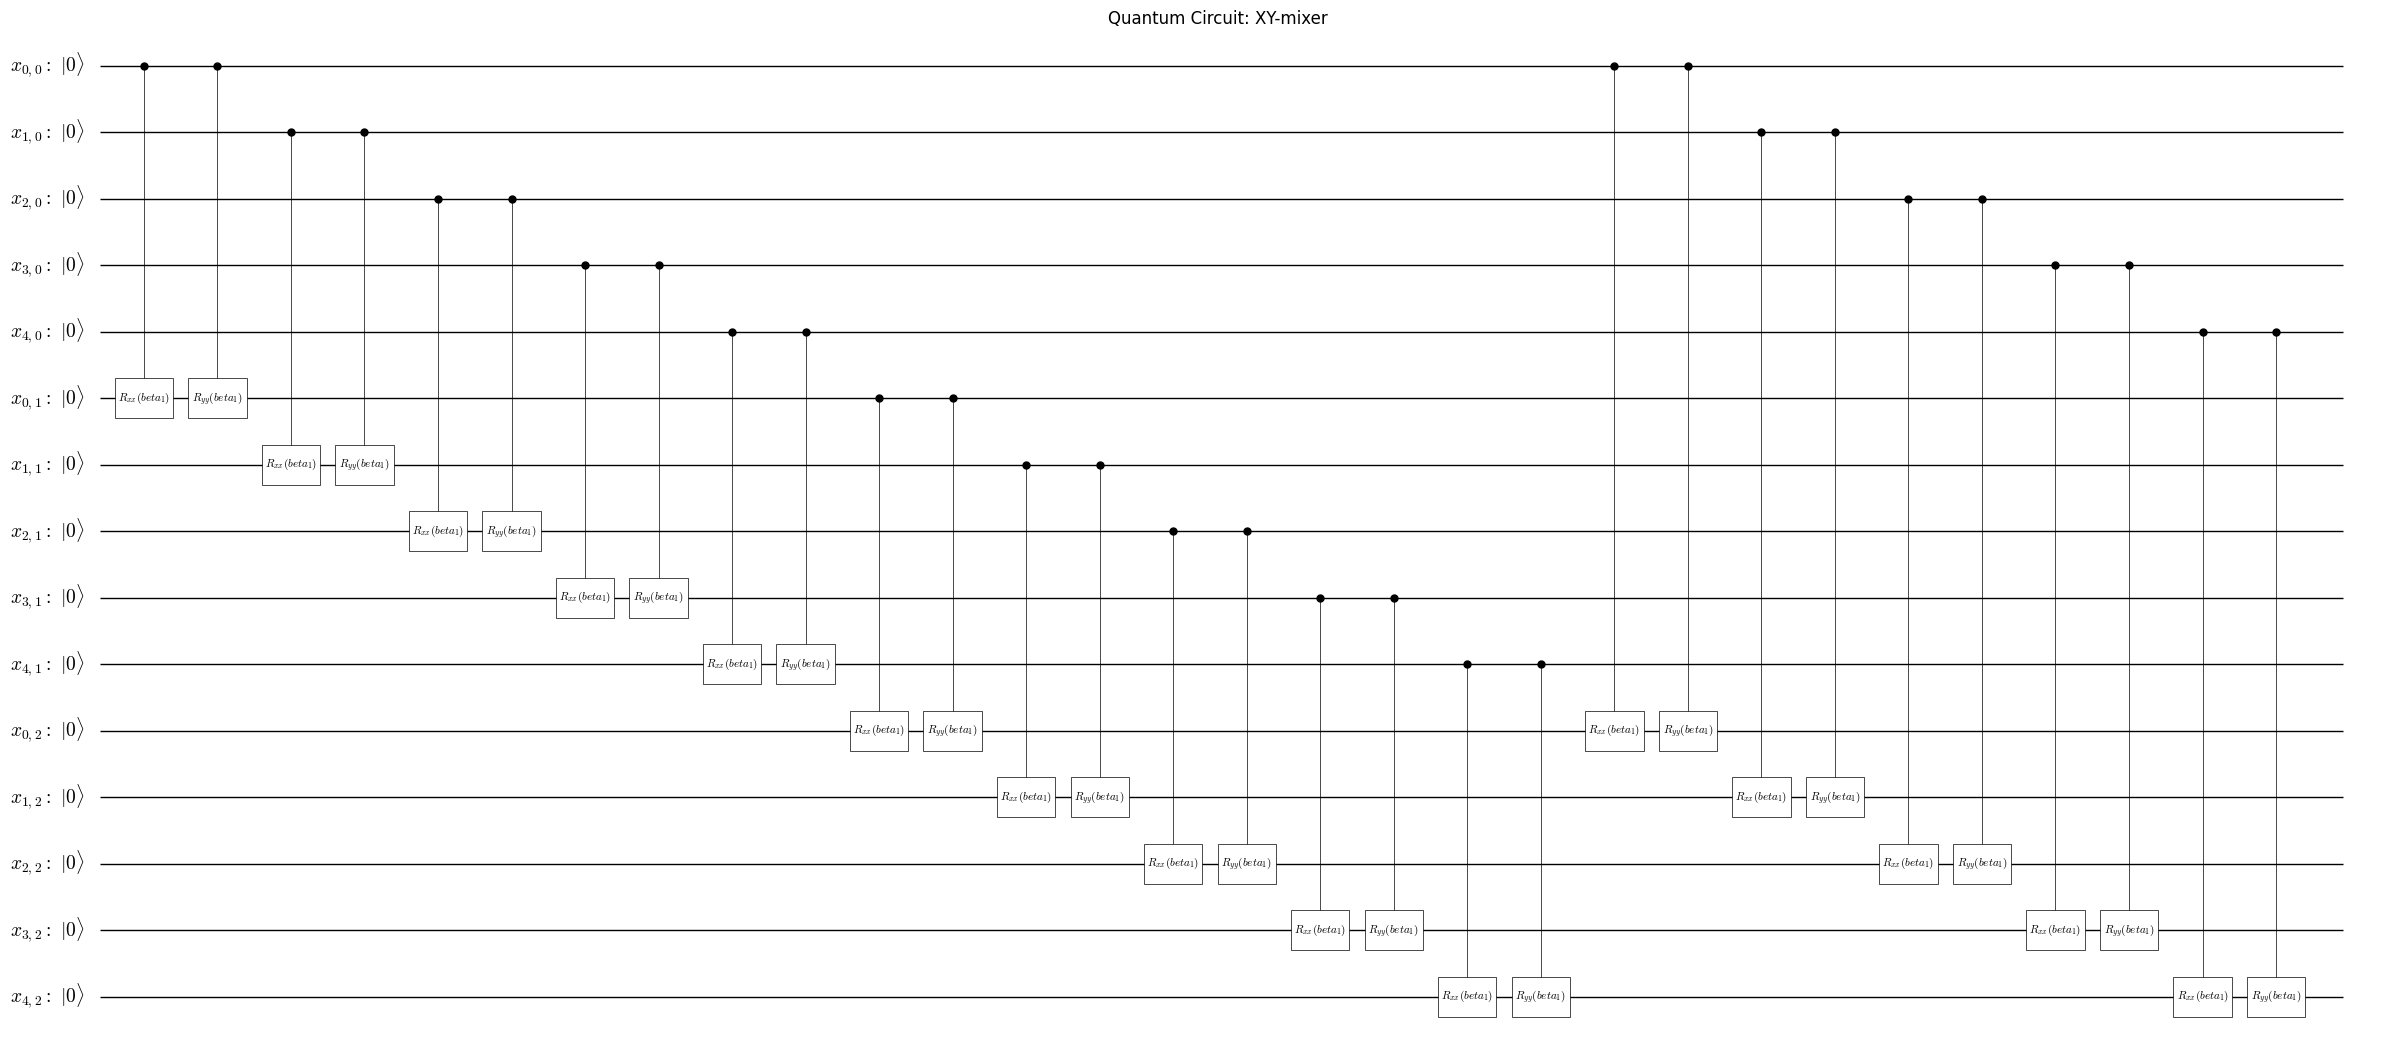

In [9]:
initial_circuit = create_initial_state(compiled_instance, num_nodes, color_num)
initial_circuit.update_qubits_label(qaoa_converter.int2varlabel)
beta_1 = qm.circuit.Parameter("beta_1")
mixer_circuit = create_xy_mixer(beta_1, num_nodes, color_num, compiled_instance)
mixer_circuit.update_qubits_label(qaoa_converter.int2varlabel)
plot_quantum_circuit(mixer_circuit)

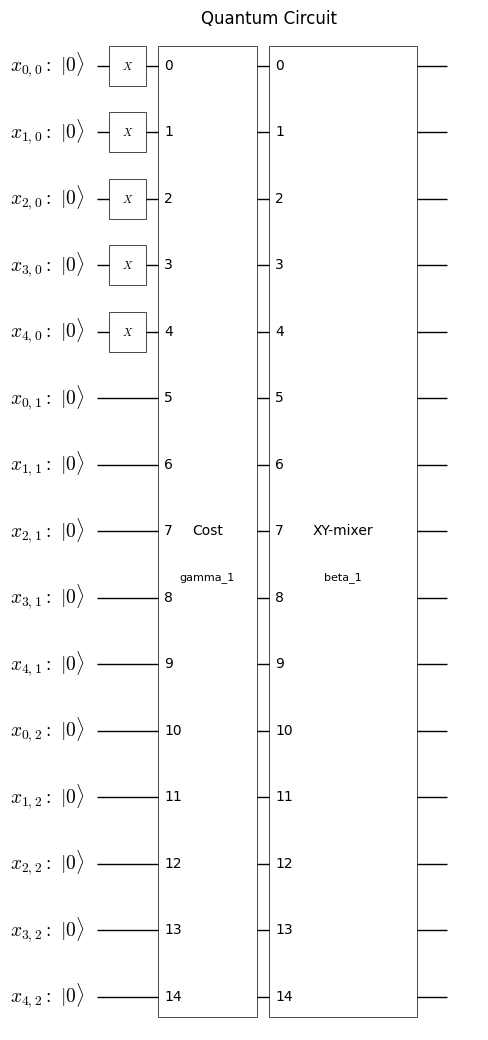

In [10]:
initial_circuit.append(qaoa_cost_circuit)
initial_circuit.append(mixer_circuit)

alternating_ansatz = initial_circuit

plot_quantum_circuit(alternating_ansatz)

## Run Quantum Alternating Operator Ansatz using Qiskit

In [11]:
qk_transpiler = QiskitTranspiler()
qk_circuit = qk_transpiler.transpile_circuit(alternating_ansatz)
qk_cost = qk_transpiler.transpile_hamiltonian(qaoa_cost)

In [12]:
# Variational Step
estimator = qk_pr.StatevectorEstimator()

cost_history = []

def estinamate_cost(params):
    job = estimator.run([(qk_circuit, qk_cost, params)])
    job_result = job.result()
    cost = job_result[0].data["evs"]
    cost_history.append(cost)
    return cost


result = opt.minimize(
    estinamate_cost, [0, 0], method="COBYLA", options={"maxiter": 100}
)
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 2.0625000215201315
       x: [ 7.853e-01  1.102e+00]
    nfev: 34
   maxcv: 0.0

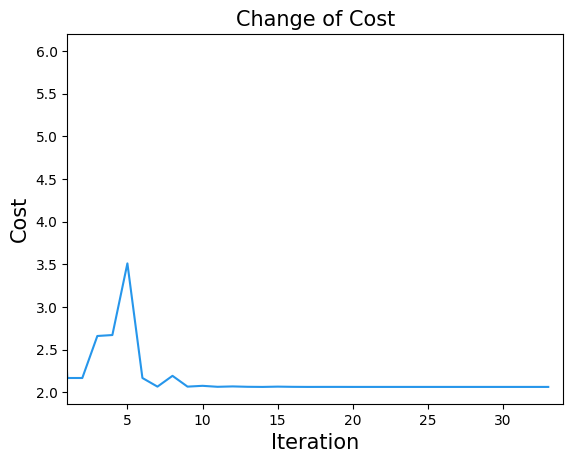

In [13]:
plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xlim(1, result.nfev)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

In [14]:
sampler = qk_pr.StatevectorSampler()
qk_circuit.measure_all()
plt.show()
job = sampler.run([(qk_circuit, result.x)])
job_result = job.result()

In [15]:
sampleset = qaoa_converter.decode(qk_transpiler, job_result[0].data['meas'])

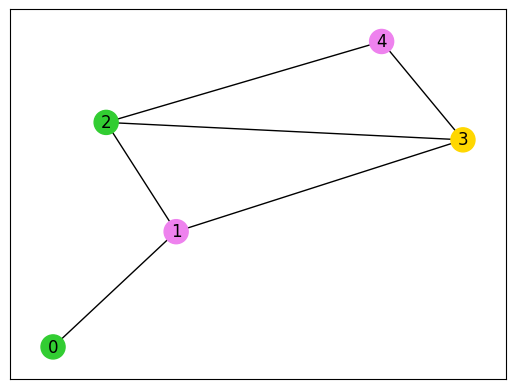

In [16]:
import numpy as np
def plot_graph_coloring(graph: nx.Graph, sampleset: jm.experimental.SampleSet):
    # extract feasible solution
    feasibles = sampleset.feasibles()
    if len(feasibles) == 0:
        print("No feasible solution found ...")
    else:
        lowest_sample = sampleset.lowest()[0]

        # get indices of x = 1
        indices = lowest_sample.var_values["x"].values.keys()
        # get vertices and colors
        # initialize vertex color list
        node_colors = [-1] * graph.number_of_nodes()
        # set color list for visualization
        colorlist = ["gold", "violet", "limegreen", "darkorange"]
        # set vertex color list
        for i, j in indices:
            node_colors[i] = colorlist[j]
        # make figure
        nx.draw_networkx(graph, node_color=node_colors, with_labels=True)
        plt.show()

plot_graph_coloring(G, sampleset)

# References
[[1] Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

[[2] Hadfield, Stuart, Zhihui Wang, Bryan O’gorman, Eleanor G. Rieffel, Davide Venturelli, and Rupak Biswas. "From the quantum approximate optimization algorithm to a quantum alternating operator ansatz." Algorithms 12, no. 2 (2019): 34.](https://arxiv.org/abs/1709.03489)